# Compute time-of-emergence!

### Load functions and packages

In [1]:
import glob
import os

import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import regionmask

import cartopy.crs as ccrs

import copy

%matplotlib inline

In [2]:
def sp_map(*nrs, projection = ccrs.PlateCarree(), **kwargs):
    return plt.subplots(*nrs, subplot_kw={'projection':projection}, **kwargs)


def to_png(file, filename, loc='/glade/u/home/jonahshaw/figures/',dpi=200,ext='png',**kwargs):
    '''
    Simple function for one-line saving.
    Saves to "/glade/u/home/jonahshaw/figures" by default
    '''
    output_dir = loc
    #ext = 'png'
    full_path = '%s%s.%s' % (output_dir,filename,ext)

    if not os.path.exists(output_dir + filename):
        file.savefig(full_path,format=ext, dpi=dpi,**kwargs)
#         file.clf()
        
    else:
        print('File already exists, rename or delete.')

## Spatial (5x5 deg.) Data

### Load processed trend data

#### Models

In [3]:
# I need to go from the CAM output variables to the CMOR/CMIP standard names.
pic_tseries_dir = '/glade/work/jonahshaw/trend_uncertainty/nathan/CMIP6_PIC/'
cesm1_dir       = 'CESM1/xagg'
mpi_dir         = 'MPI-GE/xagg'
canesm2_dir     = 'CanESM2/xagg'
esm2m_dir       = 'ESM2M/xagg'

cesm1_cmor_var_dict = {'ts':'TS','tas':'TREFHT','psl':'PSL'}

Take percentiles from PI-Control Runs of models

In [4]:
cesm1_spatial_trends_filepath   = glob.glob('%s/%s/*5x5degSpatialTrends.3_120_years.Percentiles.nc' % (pic_tseries_dir,cesm1_dir))
mpi_spatial_trends_filepath     = glob.glob('%s/%s/*5x5degSpatialTrends.3_120_years.Percentiles.nc' % (pic_tseries_dir,mpi_dir))
canesm2_spatial_trends_filepath = glob.glob('%s/%s/*5x5degSpatialTrends.3_120_years.Percentiles.nc' % (pic_tseries_dir,canesm2_dir))
esm2m_spatial_trends_filepath   = glob.glob('%s/%s/*5x5degSpatialTrends.3_120_years.Percentiles.nc' % (pic_tseries_dir,esm2m_dir))

In [5]:
cesm1_regional_trends_filepath   = glob.glob('%s/%s/*.1900trends.Percentiles*.nc' % (pic_tseries_dir,cesm1_dir))
mpi_regional_trends_filepath     = glob.glob('%s/%s/*.1900trends.Percentiles*.nc' % (pic_tseries_dir,mpi_dir))
canesm2_regional_trends_filepath = glob.glob('%s/%s/*.1900trends.Percentiles*.nc' % (pic_tseries_dir,canesm2_dir))
esm2m_regional_trends_filepath   = glob.glob('%s/%s/*.1900trends.Percentiles*.nc' % (pic_tseries_dir,esm2m_dir))

Load the trend data.

In [6]:
cesm1_pic_spatial_trends_all   = xr.open_dataarray(*cesm1_spatial_trends_filepath)

mpi_pic_spatial_trends_all     = xr.open_dataarray(*mpi_spatial_trends_filepath)

canesm2_pic_spatial_trends_all = xr.open_dataarray(*canesm2_spatial_trends_filepath)

esm2m_pic_spatial_trends_all   = xr.open_dataarray(*esm2m_spatial_trends_filepath)

In [7]:
cesm1_pic_regional_trends_all   = xr.open_dataarray(*cesm1_regional_trends_filepath).chunk({"RegionIndex": 1})
cesm1_pic_regional_trends_all["percentile"] = cesm1_pic_regional_trends_all["percentile"] * 100

mpi_pic_regional_trends_all     = xr.open_dataarray(*mpi_regional_trends_filepath).chunk({"RegionIndex": 1})
mpi_pic_regional_trends_all["percentile"] = mpi_pic_regional_trends_all["percentile"] * 100

canesm2_pic_regional_trends_all = xr.open_dataarray(*canesm2_regional_trends_filepath).chunk({"RegionIndex": 1})
canesm2_pic_regional_trends_all["percentile"] = canesm2_pic_regional_trends_all["percentile"] * 100

esm2m_pic_regional_trends_all   = xr.open_dataarray(*esm2m_regional_trends_filepath).chunk({"RegionIndex": 1})
esm2m_pic_regional_trends_all["percentile"] = esm2m_pic_regional_trends_all["percentile"] * 100

#### Observations

And the OBS-LE is effectively used as a model so I just want the percentiles.

In [8]:
obs_tseries_dir = '/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/'
gistemp_5x5_dir = 'GISTEMP_5x5/20240820/xagg/'
hadcrut5_dir = 'HadCRUT5/20240820/xagg/'
dcent_unfilled_dir = 'DCENT/20240901/xagg/'
obsle_dir       = 'mckinnon_OLENS/'

In [9]:
gistemp_tas_var = 'tas'
hadcrut5_tas_var = 'tas'
dcent_unfilled_tas_var = "temperature"
obsle_tas_var    = 'tas'

In [10]:
gistemp_5x5_spatial_trends_filepath = '%s/%s/ensembleChunks_0001_0200.trends.movingstartdate.5x5.190001-202012.nc' % (obs_tseries_dir, gistemp_5x5_dir)
hadcrut5_spatial_trends_filepath = '%s/%s/HadCRUT.5.0.2.0.001_200.trends.movingstartdate.5x5.190001-202212.nc' % (obs_tseries_dir, hadcrut5_dir)
dcent_unfilled_spatial_trends_filepath = '%s/%s/DCENT_ensemble_1850_2023.001_200.trends.movingstartdate.5x5.190001-202312.nc' % (obs_tseries_dir, dcent_unfilled_dir)
# obsle_spatial_trends_filepath        = glob.glob('%s/%s/*.5x5*1921_1922.Percentiles*.nc' % (obs_tseries_dir,obsle_dir))

In [11]:
gistemp_5x5_regional_trends_filepath = '%s/%s/ensembleChunks_0001_0200.trends.movingstartdate.IPCCRegions.190001-202012.nc' % (obs_tseries_dir,gistemp_5x5_dir)
hadcrut5_regional_trends_filepath = '%s/%s/HadCRUT.5.0.2.0.001_200.trends.movingstartdate.IPCCRegions.190001-202212.nc' % (obs_tseries_dir,hadcrut5_dir)
dcent_unfilled_regional_trends_filepath = "%s/%s/DCENT_ensemble_1850_2023.001_200.trends.movingstartdate.IPCCRegions.190001-202312.nc" % (obs_tseries_dir,dcent_unfilled_dir)
# obsle_regional_trends_filepath        = glob.glob('%s/%s/*region*1921_1925.Percentiles*.nc' % (obs_tseries_dir,obsle_dir))

Load computed start years

In [12]:
gistemp_5x5_spatial_startyears_filepath = '%s/%s/ensembleChunks_0001_0200.startyears.5x5.190001-202012.nc' % (obs_tseries_dir, gistemp_5x5_dir)
hadcrut5_spatial_startyears_filepath = '%s/%s/HadCRUT.5.0.2.0.0001_0200.startyears.5x5.190001-202412.nc' % (obs_tseries_dir, hadcrut5_dir)
dcent_unfilled_spatial_startyears_filepath = '%s/%s/DCENT_ensemble_1850_2023.001_200.startyears.5x5.190001-202312.nc' % (obs_tseries_dir, dcent_unfilled_dir)

In [13]:
gistemp_5x5_regional_startyears_filepath = '%s/%s/ensembleChunks_0001_0200.startyears.IPCCRegions.190001-202012.nc' % (obs_tseries_dir, gistemp_5x5_dir)
hadcrut5_regional_startyears_filepath = '%s/%s/HadCRUT.5.0.2.0.001_0200.startyears.IPCCRegions.190001-202412.nc' % (obs_tseries_dir, hadcrut5_dir)
dcent_unfilled_regional_startyears_filepath = "%s/%s/DCENT_ensemble_1850_2023.001_200.startyears.IPCCRegions.190001-202312.nc" % (obs_tseries_dir, dcent_unfilled_dir)

Load the trend data

In [14]:
gistemp_5x5_spatial_trends_all = xr.open_dataset(gistemp_5x5_spatial_trends_filepath)["TAS_trends"].drop_vars(['startyear', "quantile"]).squeeze()
hadcrut5_spatial_trends_all = xr.open_dataset(hadcrut5_spatial_trends_filepath)["TAS_trends"].drop_vars(['startyear', "quantile"]).squeeze().sortby("realization")
dcent_unfilled_spatial_trends_all = xr.open_dataset(dcent_unfilled_spatial_trends_filepath)["TAS_trends"].drop_vars(['startyear', "quantile"]).squeeze().sortby("realization")
# obsle_spatial_trends_all        = xr.open_dataarray(*obsle_spatial_trends_filepath).compute()

In [15]:
gistemp_regional_trends_all = xr.open_dataarray(gistemp_5x5_regional_trends_filepath).sel(startyear=1).drop_vars(['startyear', "quantile"]).chunk({"RegionIndex": 1})
hadcrut5_regional_trends_all = xr.open_dataarray(hadcrut5_regional_trends_filepath).sel(startyear=1).drop_vars(['startyear', "quantile"]).squeeze().sortby("realization").chunk({"RegionIndex": 1})
dcent_unfilled_regional_trends_all = xr.open_dataarray(dcent_unfilled_regional_trends_filepath).sel(startyear=1).drop_vars(['startyear', "quantile"]).squeeze().sortby("realization").chunk({"RegionIndex": 1})
# obsle_regional_trends_all        = xr.open_dataarray(*obsle_regional_trends_filepath)

Load the start year data

In [16]:
gistemp_5x5_spatial_startyears = xr.open_dataset(gistemp_5x5_spatial_startyears_filepath)["year"]
hadcrut5_spatial_startyears = xr.open_dataset(hadcrut5_spatial_startyears_filepath).sortby("realization")["year"]
dcent_unfilled_spatial_startyears = xr.open_dataset(dcent_unfilled_spatial_startyears_filepath).sortby("realization")["year"]

In [17]:
gistemp_regional_startyears = xr.open_dataarray(gistemp_5x5_regional_startyears_filepath)
hadcrut5_regional_startyears = xr.open_dataarray(hadcrut5_regional_startyears_filepath).sortby("realization")
dcent_unfilled_regional_startyears = xr.open_dataarray(dcent_unfilled_regional_startyears_filepath).sortby("realization")

Convert the start years across multiple realizations to the single year used for each data production (see preprocess3.5_obsIPCC_identifystartdate.ipynb)

In [18]:
def process_startyears(
    startyears: xr.DataArray,
    earliest_startyear: int,
    fillvalue: int,
    ens_dim: str = "realization",
):

    startyears_mid = startyears.quantile(0.5, dim=ens_dim)
    
    # Set values less than earliest_startyear to earliest_startyear.
    startyears_final = xr.where(
        startyears_mid > earliest_startyear,
        startyears_mid, 
        earliest_startyear,
    )
    # Revert masking to a nan
    startyears_final = startyears_final.where(startyears_final != fillvalue)
    
    return startyears_final
    

In [19]:
earliest_startyear = 1900
fillvalue = 2100

gistemp_5x5_spatial_startyears = process_startyears(
    gistemp_5x5_spatial_startyears,
    earliest_startyear=earliest_startyear,
    fillvalue=fillvalue,
).drop_vars("quantile").squeeze()
hadcrut5_spatial_startyears = process_startyears(
    hadcrut5_spatial_startyears,
    earliest_startyear=earliest_startyear,
    fillvalue=fillvalue,
).drop_vars("quantile").squeeze()
dcent_unfilled_spatial_startyears = process_startyears(
    dcent_unfilled_spatial_startyears,
    earliest_startyear=earliest_startyear,
    fillvalue=fillvalue,
).drop_vars("quantile").squeeze()

gistemp_regional_startyears = process_startyears(
    gistemp_regional_startyears,
    earliest_startyear=earliest_startyear,
    fillvalue=fillvalue,
).drop_vars("quantile").squeeze()
hadcrut5_regional_startyears = process_startyears(
    hadcrut5_regional_startyears,
    earliest_startyear=earliest_startyear,
    fillvalue=fillvalue,
).drop_vars("quantile").squeeze()
dcent_unfilled_regional_startyears = process_startyears(
    dcent_unfilled_regional_startyears,
    earliest_startyear=earliest_startyear,
    fillvalue=fillvalue,
).drop_vars("quantile").squeeze()

### Compute TTE generally

In [20]:
obs_spatial_trend_dict  = {
    'GISTEMP_5x5': gistemp_5x5_spatial_trends_all,
    'HadCRUT': hadcrut5_spatial_trends_all,
    "DCENT_unfilled": dcent_unfilled_spatial_trends_all,
}
obs_regional_trend_dict = {
    'GISTEMP_5x5': gistemp_regional_trends_all,
    'HadCRUT': hadcrut5_regional_trends_all,
    "DCENT_unfilled": dcent_unfilled_regional_trends_all,
}
obs_trend_dict = {
    'spatial':obs_spatial_trend_dict,
    'regional':obs_regional_trend_dict,
}

obs_spatial_startyear_dict  = {
    'GISTEMP_5x5': gistemp_5x5_spatial_startyears,
    'HadCRUT': hadcrut5_spatial_startyears,
    "DCENT_unfilled": dcent_unfilled_spatial_startyears
}
obs_regional_startyear_dict = {
    'GISTEMP_5x5': gistemp_regional_startyears,
    'HadCRUT': hadcrut5_regional_startyears,
    "DCENT_unfilled": dcent_unfilled_regional_startyears,
}
obs_startyear_dict = {
    'spatial':obs_spatial_startyear_dict,
    'regional':obs_regional_startyear_dict,
}

model_spatial_trend_dict = {'CESM1':cesm1_pic_spatial_trends_all,
                            'MPI':mpi_pic_spatial_trends_all,
                            'CanESM2':canesm2_pic_spatial_trends_all,
                            'ESM2M':esm2m_pic_spatial_trends_all,
                            # 'OBS-LE':obsle_spatial_trends_all,
                           }

model_regional_trend_dict = {'CESM1':cesm1_pic_regional_trends_all,
                             'MPI':mpi_pic_regional_trends_all,
                             'CanESM2':canesm2_pic_regional_trends_all,
                             'ESM2M':esm2m_pic_regional_trends_all,
                            #  'OBS-LE':obsle_regional_trends_all,
                            }
                                         
model_trend_dict          = {'spatial':model_spatial_trend_dict,
                             'regional':model_regional_trend_dict}

Compute the TTE for each ensemble member separately.

In [21]:
def compute_tte(
    obs_trends,
    pic_trends,
    startyears,
):
    '''
    General function comparing the observed trends with the PIC trends to determine TTE.
    '''
    # Can only test up to the longest sampled duration of PI-Control or observations
    duration_limit = np.minimum(obs_trends.duration.max(), pic_trends.duration.max())
    
    _tte_bool = obs_trends > pic_trends
    _tte      = _tte_bool.duration.where(~_tte_bool).max(dim='duration')
    _tte      = _tte.where(_tte != duration_limit, np.nan) # Mask the unemerged regions
    _tte      = _tte.drop_vars(['percentile'])
    
    _tte      = _tte + startyears
    
    return _tte

Ok, down to 3 minutes now which isn't terrible.

In [22]:
spatial_box = []
regional_box = []

# Iterate over regional vs. spatial
for _location_type in list(obs_trend_dict.keys()):
    
    print(_location_type)
    _box = spatial_box if (_location_type == 'spatial') else regional_box
    location_box = []
    
    _allobs_trends = obs_trend_dict[_location_type]
    _allobs_startyears = obs_startyear_dict[_location_type]
    _allmodel_trends = model_trend_dict[_location_type]
    
    for _obs_product in list(_allobs_trends.keys()):
        print(_obs_product)
        obs_box = []
        
        _obs_trends = _allobs_trends[_obs_product]
        _obs_startyears = _allobs_startyears[_obs_product]
        
        for _model_product in list(_allmodel_trends.keys()):
            print(_model_product)
            _model_trends = _allmodel_trends[_model_product]
            
            # Compute ToE of the median trend (more consistent with using the 50%ile trend for mean)
            _mean_toe = compute_tte(
                obs_trends=_obs_trends.median(dim='realization'),
                pic_trends=_model_trends.sel(percentile=97.5),
                startyears=_obs_startyears,
            )

            # Compute ToE for each ensemble member and take the 95th percentile
            _strict_toe = compute_tte(
                obs_trends=_obs_trends,
                pic_trends=_model_trends.sel(percentile=97.5),
                startyears=_obs_startyears,
            )

            # Switch nans to infs in order to compute the strict ToE correctly. Then switch infs back to nans in order to mask correctly.
            _strict_toe = _strict_toe.where(~np.isnan(_strict_toe),np.inf).quantile(q=0.95, dim='realization', method='nearest')
            _strict_toe = _strict_toe.where(~np.isinf(_strict_toe),np.nan)
            
            # Compute the delay and conditional delay mask:
            _delay_toe = _strict_toe - _mean_toe # Compute the delay
            _delay_undef_region = np.bitwise_and(np.isnan(_strict_toe), ~np.isnan(_mean_toe)) # Mask for where tas is emerged in the mean but not the "strict" sense.
            _delay_toe = xr.where(_delay_undef_region, 2020 - _mean_toe, _delay_toe) # Apply the conditional mask
            
            _toes = xr.concat([_mean_toe.assign_coords({'metric':'mean'},).expand_dims(['metric'],axis=[-1]),
                               _strict_toe.assign_coords({'metric':'strict'},).expand_dims(['metric'],axis=[-1]),
                               _delay_toe.assign_coords({'metric':'delay'},).expand_dims(['metric'],axis=[-1]),
                               _delay_undef_region.assign_coords({'metric':'delay_mask'},).expand_dims(['metric'],axis=[-1]),
                              ],
                              dim='metric',
                             )            
                              
            obs_box.append(_toes.assign_coords({'model':_model_product},).expand_dims(['model'],axis=[-1]))
                        
        location_box.append(xr.concat(obs_box,dim='model').assign_coords({'obs':_obs_product},).expand_dims(['obs'],axis=[-1]))
    _box.append(xr.concat(location_box, dim='obs').compute())
    
spatial_masked_da = spatial_box[0]
regional_masked_da = regional_box[0]

spatial
GISTEMP_5x5
CESM1
MPI
CanESM2
ESM2M
HadCRUT
CESM1
MPI
CanESM2
ESM2M
DCENT_unfilled
CESM1
MPI
CanESM2
ESM2M
regional
GISTEMP_5x5
CESM1
MPI
CanESM2
ESM2M
HadCRUT
CESM1
MPI
CanESM2
ESM2M
DCENT_unfilled
CESM1
MPI
CanESM2
ESM2M


/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/dask/utils.py:78: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/dask/utils.py:78: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/dask/utils.py:78: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/dask/utils.py:78: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/dask/utils.py:78: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/dask/utils.py:78: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/glade/work/jonahshaw/conda-envs/p

In [23]:
spatial_masked_da.name = "ToE"
regional_masked_da.name = "ToE"

In [24]:
toe_savedir = "/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/ToE_output"

spatial_masked_da.to_netcdf(f"{toe_savedir}/ToE_delay.5x5.nc")
regional_masked_da.to_netcdf(f"{toe_savedir}/ToE_delay.IPCCRegions.nc")

### Other tests

Testing out the DCENT spatial data because the results seem a bit sparse.

In [ ]:
# dcent_unfilled_spatial_trends_all
# dcent_unfilled_spatial_startyears
# cesm1_pic_spatial_trends_all

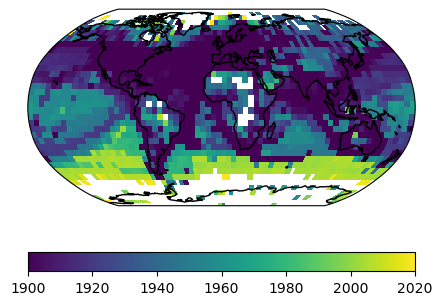

In [25]:
mask = dcent_unfilled_spatial_startyears #.plot()

fig,ax = sp_map(1,1,projection=ccrs.Robinson(),figsize=(5, 4))

im = ax.pcolormesh(
    mask.lon,
    mask.lat,
    mask,
    transform=ccrs.PlateCarree(),
    # cmap=_cmap,
    # norm=_norm, 
)

ax.coastlines()
ax.set_global()

plt.colorbar(im, orientation="horizontal")

In [ ]:
# Test out lat 37.5, lon -157.5.
# This region has a relatively early DCENT start year but is not detected, this seems suspect.

# Test out lat 27.5, lon -37.5.
# This is the north atlantic where DCENT has a 1900 start date but emerges much later than GISTEMP or HadCRUT

# Test out lat -42.5, lon 22.5.
# This is off of the Cape of Good Hope. There really isn't good DCENT start availability here, so I'm not sure how it got a 1900 start year...

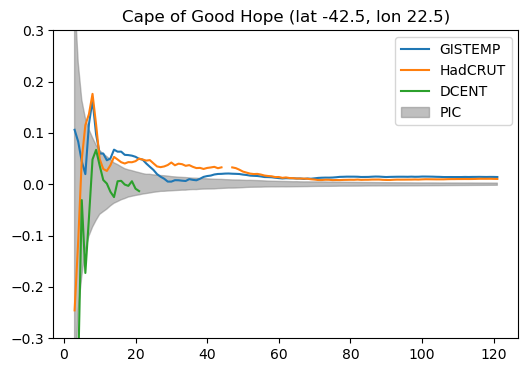

In [26]:
testlat = -42.5
testlon = 22.5

fig, ax = plt.subplots(1, 1, figsize=(6,4))

ax.plot(
    gistemp_5x5_spatial_trends_all.sel(lat=testlat, lon=testlon, realization=1).duration,
    gistemp_5x5_spatial_trends_all.sel(lat=testlat, lon=testlon, realization=1),
    label="GISTEMP",
)
ax.plot(
    hadcrut5_spatial_trends_all.sel(lat=testlat, lon=testlon, realization=1).duration,
    hadcrut5_spatial_trends_all.sel(lat=testlat, lon=testlon, realization=1),
    label="HadCRUT",
)
ax.plot(
    dcent_unfilled_spatial_trends_all.sel(lat=testlat, lon=testlon, realization=1).duration,
    dcent_unfilled_spatial_trends_all.sel(lat=testlat, lon=testlon, realization=1),
    label="DCENT",
)

ax.fill_between(
    cesm1_pic_spatial_trends_all.sel(lat=testlat, lon=testlon).duration,
    cesm1_pic_spatial_trends_all.sel(lat=testlat, lon=testlon, percentile=2.5),
    cesm1_pic_spatial_trends_all.sel(lat=testlat, lon=testlon, percentile=97.5),
    color="grey",
    label="PIC",
    alpha=0.5
)

ax.set_ylim(-0.3, 0.3)
ax.set_title(f"Cape of Good Hope (lat {testlat}, lon {testlon})")

plt.legend()

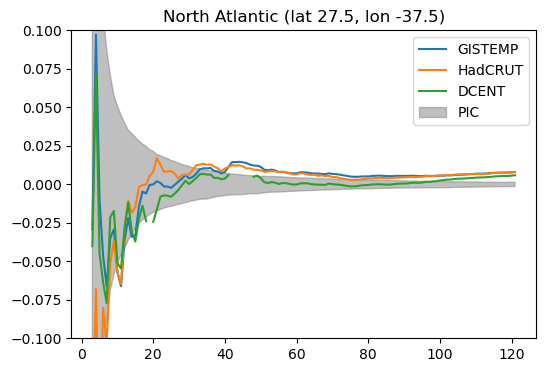

In [27]:
testlat = 27.5
testlon = -37.5

fig, ax = plt.subplots(1, 1, figsize=(6,4))

ax.plot(
    gistemp_5x5_spatial_trends_all.sel(lat=testlat, lon=testlon, realization=1).duration,
    gistemp_5x5_spatial_trends_all.sel(lat=testlat, lon=testlon, realization=1),
    label="GISTEMP",
)
ax.plot(
    hadcrut5_spatial_trends_all.sel(lat=testlat, lon=testlon, realization=1).duration,
    hadcrut5_spatial_trends_all.sel(lat=testlat, lon=testlon, realization=1),
    label="HadCRUT",
)
ax.plot(
    dcent_unfilled_spatial_trends_all.sel(lat=testlat, lon=testlon, realization=1).duration,
    dcent_unfilled_spatial_trends_all.sel(lat=testlat, lon=testlon, realization=1),
    label="DCENT",
)

ax.fill_between(
    cesm1_pic_spatial_trends_all.sel(lat=testlat, lon=testlon).duration,
    cesm1_pic_spatial_trends_all.sel(lat=testlat, lon=testlon, percentile=2.5),
    cesm1_pic_spatial_trends_all.sel(lat=testlat, lon=testlon, percentile=97.5),
    color="grey",
    label="PIC",
    alpha=0.5
)

ax.set_ylim(-0.1, 0.1)
ax.set_title("North Atlantic (lat 27.5, lon -37.5)")

plt.legend()

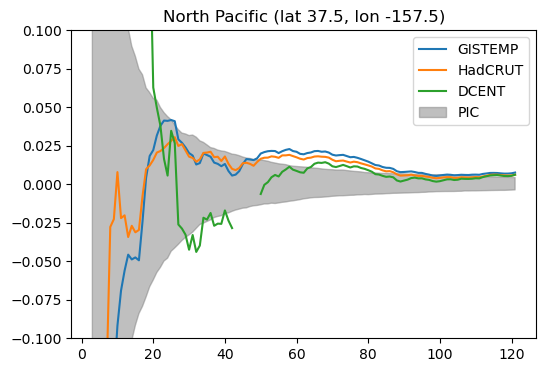

In [28]:
testlat = 37.5
testlon = -157.5

fig, ax = plt.subplots(1, 1, figsize=(6,4))

ax.plot(
    gistemp_5x5_spatial_trends_all.sel(lat=testlat, lon=testlon, realization=1).duration,
    gistemp_5x5_spatial_trends_all.sel(lat=testlat, lon=testlon, realization=1),
    label="GISTEMP",
)
ax.plot(
    hadcrut5_spatial_trends_all.sel(lat=testlat, lon=testlon, realization=1).duration,
    hadcrut5_spatial_trends_all.sel(lat=testlat, lon=testlon, realization=1),
    label="HadCRUT",
)
ax.plot(
    13 + dcent_unfilled_spatial_trends_all.sel(lat=testlat, lon=testlon, realization=1).duration,
    dcent_unfilled_spatial_trends_all.sel(lat=testlat, lon=testlon, realization=1),
    label="DCENT",
)

ax.fill_between(
    cesm1_pic_spatial_trends_all.sel(lat=testlat, lon=testlon).duration,
    cesm1_pic_spatial_trends_all.sel(lat=testlat, lon=testlon, percentile=2.5),
    cesm1_pic_spatial_trends_all.sel(lat=testlat, lon=testlon, percentile=97.5),
    color="grey",
    label="PIC",
    alpha=0.5
)

ax.set_ylim(-0.1, 0.1)
ax.set_title("North Pacific (lat 37.5, lon -157.5)")

plt.legend()

Ok, this region seems to make sense with the insight of the cone plot. The DCENT trends are less positive because of the excluded region and the ICV cone is larger.